## 2.5 Average Consensus

Given a network of $n$ computing agents, the combination matrix $W$, and the local variables $x_1^0, \cdots, x_n^0$, the average consensus algorithm is  

$$x_i^{k} = \sum_{j=1}^n w_{ij} x_j^{k-1} = w_{ii} x_i^{k-1} + \sum_{j\in \mathcal{N}(i)} w_{ij} x_j^{k-1}, \quad \forall\ i=1,\cdots, n.$$

Average consensus is a recursive algorithm. Each recursion only incurs neighborhood communication. Each recursion of average consensus is conducted in parallel. By repeating a series of partial averaging, it is guaranteed by theory that $x_i^{k} \to \bar{x}^0 = \frac{1}{n}\sum_{i=1}^n x_i^0$. See Sec. \[Average consensus proof\]. 

**Average consensus algorithm is the foundation of decentralized optimization. All decentralized optimization algorithms we will discuss in later sections will rely on average consensus.**


Before we disscuss how to implement average consensus, we neeed to import necessary modules and initialize BlueFog.

In [1]:
import numpy as np
import bluefog.torch as bf
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
from bluefog.common import topology_util
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ipyparallel as ipp

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [3]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 6 among 8 processes
[stdout:1] Hello, I am 5 among 8 processes
[stdout:2] Hello, I am 0 among 8 processes
[stdout:3] Hello, I am 2 among 8 processes
[stdout:4] Hello, I am 7 among 8 processes
[stdout:5] Hello, I am 3 among 8 processes
[stdout:6] Hello, I am 4 among 8 processes
[stdout:7] Hello, I am 1 among 8 processes


In [4]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

In [5]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


### 2.5.1 Implementing average consensus using topologies provided by BlueFog

In BlueFog, we provide a ```neighbor_allreduce``` primitive to support neighborhood paritial averaging. In this example, we will implement average consenus with BlueFog and examine that each local variable will asymptotically achieve the global average.

We first set up some parameters. Since BlueFog is partially built upon PyTorch, it supports the tensor operation well. For this reason, we will use ```torch``` rather than ```numpy``` to generate and manipulate variables.

In [6]:
%%px 
# Generate parameters 
d = 10     # Dimension of each local variable
x = torch.randn((d, 1))     # Randomly generate a local random variable x_i

As a control experiment, we first calculate the global average $\bar{x}^0 = \frac{1}{n}\sum_{i=1}^n x_i^0$ with ```allreduce```, which is also supported by BlueFog. By runing the following one-line code, you should be able to get the global average of all local variables.

In [7]:
%%px

# generate in the notebook and push it to each agent

x_global_average = bf.allreduce(x)

if bf.rank() == 0:
    print('The global average of each local variable is:')
    print(x_global_average)

[stdout:2] 
The global average of each local variable is:
tensor([[-0.0625],
        [ 0.6569],
        [ 0.2745],
        [-0.3293],
        [-0.1936],
        [ 0.1906],
        [ 0.1960],
        [ 0.4484],
        [ 0.4996],
        [ 0.3463]])


Now we implement the average consensus with BlueFog. To begin with, we need to set up the topology. In this example, we use the topology provided by BlueFog. Do not forget to set the topology.

In [8]:
%%px

# Set topology as the exponential graph.
G = topology_util.ExponentialTwoGraph(bf.size())
assert bf.set_topology(G)

Implement one step of the average consensus recursion.

In [9]:
%%px 

def avg_consensus_one_step(x):
    # one-step average consensus. The combination weights have been determined by the assoxiated 
    # combination matrix.
    x_new = bf.neighbor_allreduce(x)
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_global_average, p=2)/torch.norm(x_global_average,p=2)

    return x_new, rel_error

Implement the complete average consensus algorihtm over 8 GPUs.

In [10]:
%%px

maxite = 50

rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = avg_consensus_one_step(x)

[stdout:2] 
Progress 0/50
Progress 10/50
Progress 20/50
Progress 30/50
Progress 40/50


Draw the convergence curves of one agent. It is observed that the relative error converges to zero at linear rate.

Text(0, 0.5, 'Relative error')

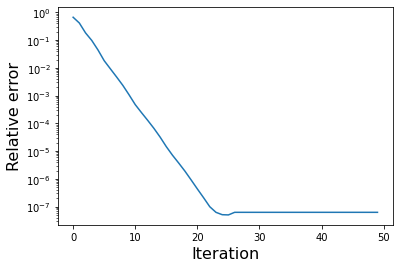

In [11]:
rel_error = dview.pull('rel_error', block=True, targets=0)
plt.semilogy(rel_error)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

In the above plot, the Relative error indicates $\|x_i^{(k)} - \bar{x}^{(0)}\|/\|\bar{x}^{(0)}\|$. It is observed that the relative error converges to $10^{-7}$ which indicates that $x_i^{(k)}$ convergs to $\bar{x}^{(0)}$ gradually. One can achieve even smaller relative error around $10^{-14}$ with tensors with precision of 64-bit floating point.

### 2.5.2 Implementing average consensus using your own topologies

In this example, we organize all agents as the random geometric topology and then run average consensus. As we discussed in Sec. 2.3, the random geometric topology is not supported by BlueFog and one has to generate its combination matrix first, set up the topology as random geometric topology, and run average consensus.


**Step I: Generate combinatioin matrix $W$**

All functions below have been discussed in Sec. 2.3.

In [12]:
def gen_comb_matrix_via_MH(A):
    
    '''
    Input:  adjacency matirx A: numpy 2D array with dims (n,n)
    Output: combination matrix W: numpy 2D array with dims (n,n)
    '''
    
    # the adjacency matrix must be symmetric
    assert np.linalg.norm(A - A.T) < 1e-6
    
    # make sure the diagonal elements of A are 0
    n, _ = A.shape
    for i in range(n):
        A[i,i] = 0
        
    # compute the degree of each agent
    d = np.sum(A, axis=1)
    
    # identify the neighbor of each agent
    neighbors = {}
    for i in range(n):
        neighbors[i] = set()
        for j in range(n):
            if A[i,j] == 1:
                neighbors[i].add(j)
                
    # generate W via M-H rule
    W = np.zeros((n,n))
    for i in range(n):
        for j in neighbors[i]:
            W[i,j] = 1/(1+np.maximum(d[i], d[j]))
            
    W_row_sum = np.sum(W,axis=1)
    for i in range(n):
        W[i,i] = 1 - W_row_sum[i]
    
    return W

def gen_random_geometric_topology(num_agents, r):
    
    '''
    num_agents: the number of agents in the network
    r: two agents within the distance 'r' are regarded as neighbors
    '''
    
    # Generate n random 2D coordinates within a 1*1 square
    agents = {}
    for i in range(num_agents):
        agents[i] = np.random.rand(2,1)
        
    A = np.zeros((num_agents, num_agents))
    for i in range(num_agents):
        for j in range(i+1, num_agents):
            dist = np.linalg.norm(agents[i] - agents[j])
            if dist < r:
                A[i,j] = 1
                A[j,i] = 1
                
    return A

The adjacency matrix of the generated network is:
[[0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0.]]


The associated combination matrix is:
[[0.3  0.   0.   0.2  0.25 0.   0.25 0.  ]
 [0.   0.3  0.   0.2  0.   0.25 0.   0.25]
 [0.   0.   0.75 0.   0.   0.   0.25 0.  ]
 [0.2  0.2  0.   0.2  0.2  0.   0.   0.2 ]
 [0.25 0.   0.   0.2  0.3  0.   0.25 0.  ]
 [0.   0.25 0.   0.   0.   0.75 0.   0.  ]
 [0.25 0.   0.25 0.   0.25 0.   0.25 0.  ]
 [0.   0.25 0.   0.2  0.   0.   0.   0.55]]


W is symmetric.
W is doubly stochastic.


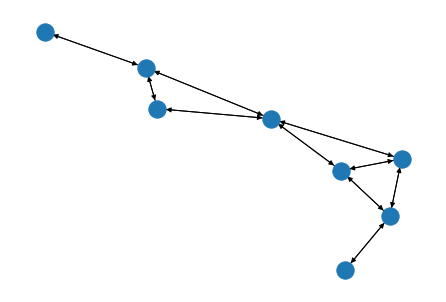

In [13]:
np.random.seed(seed=2021)

num_nodes = len(rc.ids)
A = gen_random_geometric_topology(num_agents=num_nodes, r=0.5)
print('The adjacency matrix of the generated network is:')
print(A)

print('\n')
print('The associated combination matrix is:')
W = gen_comb_matrix_via_MH(A)
print(W)

# test whether it is symmetric and doubly stochastic
print('\n')
if np.linalg.norm(W-W.T) == 0:
    print('W is symmetric.')
    
if np.sum(W,axis=0).all() == 1 and np.sum(W,axis=1).all() == 1:
    print('W is doubly stochastic.')
    
# generate topology from W
G = nx.from_numpy_array(W, create_using=nx.DiGraph)

# draw topology
nx.draw_spring(G)

**Step II: Set up topology**

we push the combination matrix to each agent.

In [14]:
dview.push({'W': W}, block=True)

[None, None, None, None, None, None, None, None]

Organize all agents into the predefined topology by $W$. For your own topology, do not forget to set **is_weighted=True** in ```bf.set_topology()```.

In [15]:
%%px
# set up the topology
G = nx.from_numpy_array(W, create_using=nx.DiGraph)
bf.set_topology(G, is_weighted=True)
# bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

# Generate parameters 
np.random.seed(seed=2021)
d = 10     # Dimension of each local variable
x = torch.randn((d, 1))     # Randomly generate a local random variable x_i

# Get the global average
x_global_average = bf.allreduce(x)

In [16]:
%%px

maxite = 200

rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = avg_consensus_one_step(x)

[stdout:2] 
Progress 0/200
Progress 10/200
Progress 20/200
Progress 30/200
Progress 40/200
Progress 50/200
Progress 60/200
Progress 70/200
Progress 80/200
Progress 90/200
Progress 100/200
Progress 110/200
Progress 120/200
Progress 130/200
Progress 140/200
Progress 150/200
Progress 160/200
Progress 170/200
Progress 180/200
Progress 190/200


Text(0, 0.5, 'Relative error')

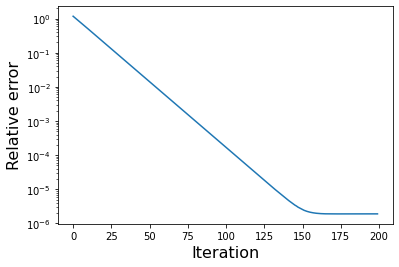

In [17]:
rel_error = dview.pull('rel_error', block=True, targets=0)
plt.semilogy(rel_error)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

It is observed that $x_i^{(k)}$ convergs to $\bar{x}^{(0)}$ gradually.